In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import plotly.graph_objects as go
import scipy.io as scio
import random
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [22]:
def projectile_motion_with_resistance(state, t, g, k):
    y, v_y = state
    n = 1
    dy_dt = v_y
    dv_y_dt = -g - (k/m) * v_y**n
    
    return [dy_dt, dv_y_dt]

# 定义参数
g = 9.8  # 重力加速度
k = 0.01  # 空气阻力系数
m = 1.0  # 物体质量

# 定义初始条件

y0 = 75  # 初始垂直位置

v_y0 = 272  # 初始垂直速度

# 定义时间点
ts = np.linspace(0, 2, 1000)  # 从0到2秒，共取100个时间点

# 定义初始状态向量
initial_state = [y0, v_y0]

# 求解ODE方程组
solution_with_resistance = odeint(projectile_motion_with_resistance, initial_state, ts, args=(g, k))

# 提取位置和速度信息

y_with_resistance = solution_with_resistance[:, 0]

v_y_with_resistance = solution_with_resistance[:, 1]

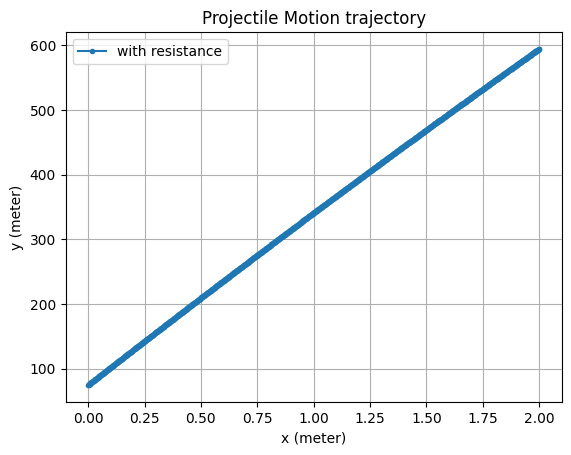

In [23]:
# 绘制轨迹
plt.plot(ts, y_with_resistance, label = 'with resistance', marker='o', markersize = 3)
#plt.plot(state_list[:, 0], state_list[:, 1], label = 'Kalman Filter tracking', marker='o', markersize = 3)
plt.xlabel('x (meter)')
plt.ylabel('y (meter)')
plt.title('Projectile Motion trajectory')
plt.grid(True)
plt.legend()
plt.show()

In [4]:
n_train = 800
t_train = ts[:n_train]
x_train = x_with_resistance[:n_train]
y_train = y_with_resistance[:n_train]

In [8]:
# data preparation
n_f = 10000
f_batch_size = 32

reg_in = torch.from_numpy(t_train).type(torch.float32)
reg_in = reg_in[:,None]

reg_ylabel = torch.from_numpy(y_train).type(torch.float32)
reg_ylabel = reg_ylabel[:,None]

print(reg_ylabel)
f_y = np.random.uniform(0, 5, n_f)
f_yt = np.random.uniform(0, 2, n_f)

f_data_y = np.vstack([f_y, f_yt]).T

f_y = Variable(torch.from_numpy(f_data_y[:, 0:1]).type(torch.FloatTensor), requires_grad=True)
f_yt = Variable(torch.from_numpy(f_data_y[:, 1:2]).type(torch.FloatTensor), requires_grad=True)

f_dataset_y = torch.utils.data.TensorDataset(f_y, f_yt)
f_data_loader_y = torch.utils.data.DataLoader(f_dataset_y, batch_size = f_batch_size, shuffle=True)

tensor([[10.0000],
        [10.0000],
        [ 9.9999],
        [ 9.9998],
        [ 9.9997],
        [ 9.9995],
        [ 9.9993],
        [ 9.9990],
        [ 9.9987],
        [ 9.9984],
        [ 9.9980],
        [ 9.9976],
        [ 9.9972],
        [ 9.9967],
        [ 9.9962],
        [ 9.9956],
        [ 9.9950],
        [ 9.9943],
        [ 9.9936],
        [ 9.9929],
        [ 9.9921],
        [ 9.9913],
        [ 9.9905],
        [ 9.9896],
        [ 9.9887],
        [ 9.9877],
        [ 9.9867],
        [ 9.9857],
        [ 9.9846],
        [ 9.9835],
        [ 9.9823],
        [ 9.9811],
        [ 9.9799],
        [ 9.9786],
        [ 9.9773],
        [ 9.9760],
        [ 9.9746],
        [ 9.9731],
        [ 9.9717],
        [ 9.9701],
        [ 9.9686],
        [ 9.9670],
        [ 9.9654],
        [ 9.9637],
        [ 9.9620],
        [ 9.9603],
        [ 9.9585],
        [ 9.9567],
        [ 9.9548],
        [ 9.9529],
        [ 9.9509],
        [ 9.9490],
        [ 9.

In [6]:
# Define a MLP and function f
class MLP(nn.Module):
    def __init__(self, in_dim = 1,  hidden_dim = 128, out_dim = 1):

        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
                                nn.Linear(in_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, out_dim),
                                        )

    def forward(self, data_in):
        return self.mlp(data_in)

model = MLP()

class f_t(nn.Module):

    def __init__(self):

        super(f_t, self).__init__()
        self.k = nn.Parameter(1*torch.ones(1, ), requires_grad=True)

    def forward(self, t):
        u = model(t)
        u_t_y = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                                  create_graph=True, retain_graph=True)[0]
        u_tt_y = torch.autograd.grad(u_t_y, t, grad_outputs=torch.ones_like(u),
                                  create_graph=True, retain_graph=True)[0]
        return u_tt_y + (self.k)*u_t_y**3 + 9.8

In [7]:
# Training the PINN
n_epoch = 50
f_model = f_t()
paras = list(model.parameters()) + list(f_model.parameters())
optimizer_y = optim.Adam(paras, lr=1e-3)
Alpha_k = np.zeros(n_epoch,)
Alpha_m = np.zeros(n_epoch,)
Alpha_n = np.zeros(n_epoch,)

for epoch in range(n_epoch):
    for x, t in tqdm(f_data_loader_y):

        optimizer_y.zero_grad()
        pred = model(reg_in)
        reg_loss = torch.mean((reg_ylabel - pred) ** 2)
        
        f_loss = torch.mean(f_model(t) ** 2)

        loss =  reg_loss +f_loss   # adjust the coefficients between two losses
        loss.backward(retain_graph=True)
        optimizer_y.step()

    print("epoch = {}, loss = {}".format(epoch, loss))
    print("epoch = {}, f_loss = {}".format(epoch, f_loss))
    print("epoch = {}, reg_loss = {}".format(epoch, reg_loss))

    Alpha_k[epoch] = f_model.k.detach().numpy().item()
    #Alpha_m[epoch] = f_model.m.detach().numpy().item()
    #Alpha_n[epoch] = f_model.n.detach().numpy().item()


100%|██████████| 313/313 [00:01<00:00, 192.99it/s]


epoch = 0, loss = 0.8729700446128845
epoch = 0, f_loss = 0.010512745007872581
epoch = 0, reg_loss = 0.862457275390625


100%|██████████| 313/313 [00:01<00:00, 200.81it/s]


epoch = 1, loss = 0.8448306918144226
epoch = 1, f_loss = 0.008963454514741898
epoch = 1, reg_loss = 0.8358672261238098


 97%|█████████▋| 303/313 [00:01<00:00, 198.32it/s]


KeyboardInterrupt: 

In [ ]:
# Train a pure MLP in x direction
model_mlp = MLP()
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3)
for epoch in range(1000):

        optimizer_mlp.zero_grad()
        pred = model_mlp(reg_in)
        mlp_loss = torch.mean((reg_ylabel - pred) ** 2)
        mlp_loss.backward()
        optimizer_mlp.step()
        print("epoch = {}, loss = {}".format(epoch, mlp_loss))

epoch = 0, loss = 57.988555908203125
epoch = 1, loss = 52.87834930419922
epoch = 2, loss = 47.908355712890625
epoch = 3, loss = 42.95734405517578
epoch = 4, loss = 38.009437561035156
epoch = 5, loss = 33.13569641113281
epoch = 6, loss = 28.438756942749023
epoch = 7, loss = 24.032106399536133
epoch = 8, loss = 20.02239418029785
epoch = 9, loss = 16.491710662841797
epoch = 10, loss = 13.484400749206543
epoch = 11, loss = 11.003559112548828
epoch = 12, loss = 9.017163276672363
epoch = 13, loss = 7.469623565673828
epoch = 14, loss = 6.294219970703125
epoch = 15, loss = 5.423216342926025
epoch = 16, loss = 4.794432163238525
epoch = 17, loss = 4.354419231414795
epoch = 18, loss = 4.0591654777526855
epoch = 19, loss = 3.8733487129211426
epoch = 20, loss = 3.7689597606658936
epoch = 21, loss = 3.7238354682922363
epoch = 22, loss = 3.7203779220581055
epoch = 23, loss = 3.744556188583374
epoch = 24, loss = 3.785184383392334
epoch = 25, loss = 3.833430767059326
epoch = 26, loss = 3.88246989250183

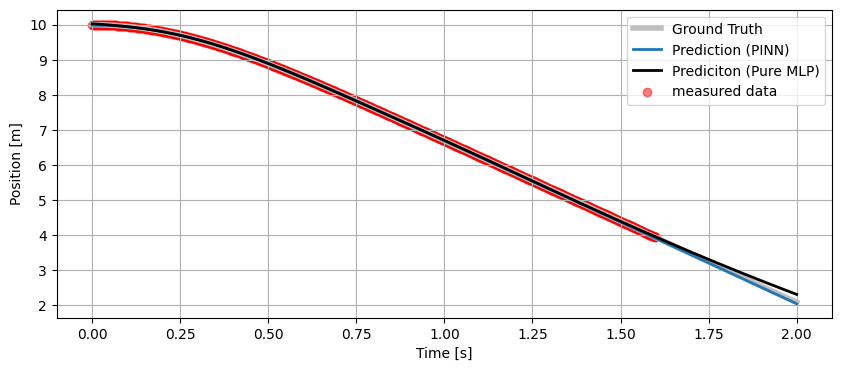

In [ ]:
# Time series

ts_torch = torch.from_numpy(ts).type(torch.float32)
ts_torch = ts_torch[:,None]

plt.figure(figsize=(10, 4))
plt.plot(ts, y_with_resistance,color = "silver", lw = 4)
plt.plot(ts, model( ts_torch )[:,0:1].detach().numpy(),lw = 2)
plt.plot(ts, model_mlp( ts_torch )[:,0:1].detach().numpy(), color = "black", lw = 2)
plt.scatter(t_train, y_train,alpha=0.5, c = "red")
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['Ground Truth', 'Prediction (PINN)', "Prediciton (Pure MLP)","measured data"])
plt.grid(True)

Parameter containing:
tensor([0.0973], requires_grad=True)


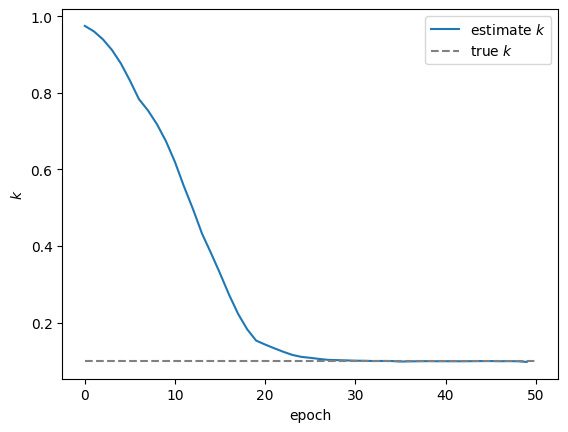

In [ ]:
print(f_model.k)

plt.plot(np.asarray(Alpha_k), label = r"estimate $k$")
plt.plot(np.linspace(0,n_epoch, n_epoch), k*np.ones(n_epoch),"--", color = "gray", label = r"true $k$")
plt.ylabel(r"$k$")
plt.xlabel("epoch")
plt.legend()